Review the overview of this project: https://github.com/liwen611/project-bitcoin/blob/master/bitcoin_overview.ipynb

Review the linear regression model and the random forest model: https://github.com/liwen611/project-bitcoin/blob/master/multilinear_and_rf.ipynb


This notebook works to predict the bitcoin price index using time series analysis.

# The Bitcoin Price Index Time Series

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('seaborn-poster')
%matplotlib inline 

In the Overview chapeter, we have already seen the original time series of the bitcoin price index which flutuate quite a bit over time. First we will transform this original series to a log scale so it is easier to work with it later. Compare the series before and after the transformation.

In this notebook, we continue to use the same dataset downloadable here: 
https://www.kaggle.com/mczielinski/bitcoin-historical-data

Again, in doing analysis, we might not need the minute to minute information so we downsample the datapoint to day and month.

In [2]:
bit = pd.read_csv('data/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv', usecols = ['Timestamp', 'Weighted_Price'])
bit['Timestamp'] = pd.to_datetime(bit['Timestamp'], unit='s')
bit = bit.set_index('Timestamp')

In [3]:
# downsample by day and month
bit_daily = bit.resample('D').mean()
bit_monthly = bit.resample('M').mean()
# take log of the original series to stablized it
bit_daily_log = np.log(bit_daily)
bit_monthly_log = np.log(bit_monthly)

In [6]:
bit_daily.head()

,Weighted_Price
Timestamp,
2011-12-31,4.471603
2012-01-01,4.806667
2012-01-02,5.000000
2012-01-03,5.252500
2012-01-04,5.208159


In [7]:
bit_monthly.head()

,Weighted_Price
Timestamp,
2011-12-31,4.471603
2012-01-31,6.345955
2012-02-29,5.228443
2012-03-31,4.984397
2012-04-30,4.995091


In [4]:
# save the data to csv
# bit_daily.to_csv('bit_daily.csv')
# bit_monthly.to_csv('bit_monthly.csv')

/Users/liwenhuang/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


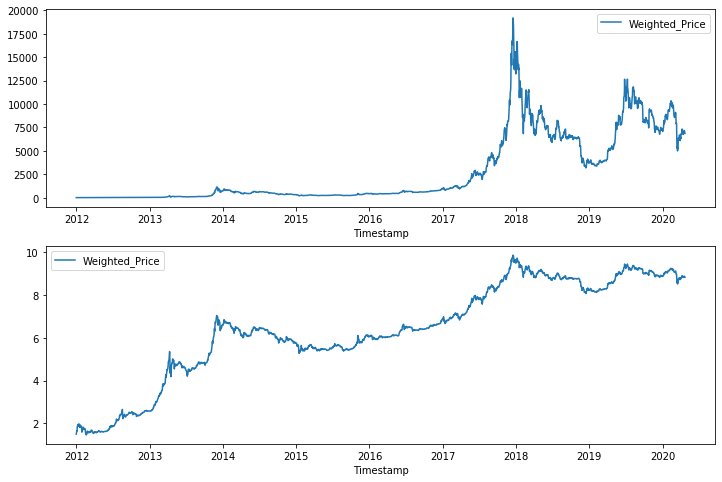

In [5]:
plt.figure(figsize = (12, 8))
plt.subplot(211)
sns.lineplot(data = bit_daily)
plt.subplot(212)
sns.lineplot(data = bit_daily_log)

plt.savefig('bit_trend.png')

We can see that after using log method to stablized the original time series, the bitcoin price index stills shows a pretty strong upward trend.

# ACF and Seasonal Decomposition

The first step to model a time series is to do stationary check. In this session, we analyze the the autocorrlation of the bitcoin price index in periods of day, week, month, and quarters. We first work on the original time series but we do not expect to find a stationary series

In [7]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf 
from itertools import product
from datetime import datetime

## The Original Time Series

In [5]:
# we already have the daily and monthly, downsample the weekly, quartly, and annual series
bit_weekly = bit_daily.resample('W').mean()
bit_quarterly = bit_daily.resample('Q').mean()
bit_annual = bit_daily.resample('A').mean()
# take log of the original series to stablized it
bit_weekly_log = np.log(bit_weekly)
bit_quarterly_log = np.log(bit_quarterly)
bit_annual_log = np.log(bit_annual)

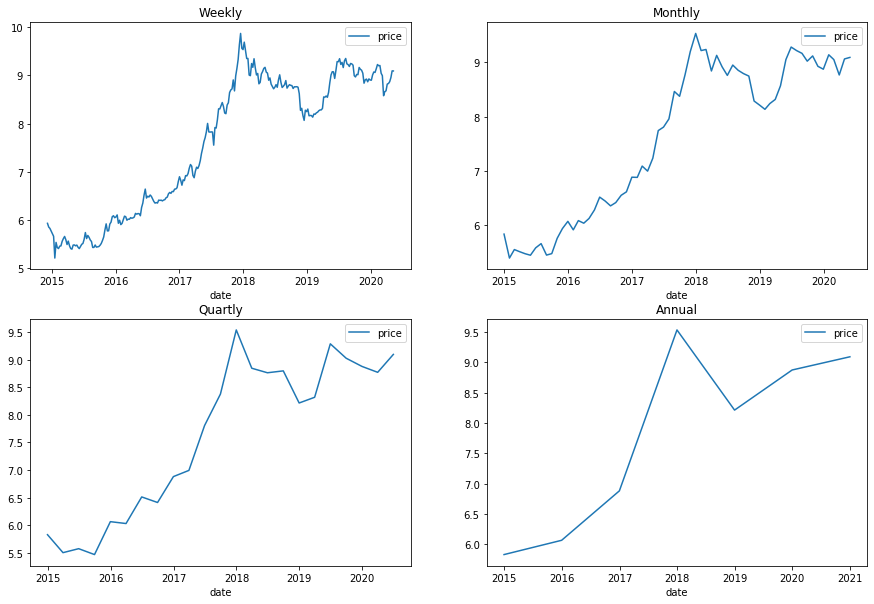

In [216]:
plt.figure(figsize = (15, 10))
plt.subplot(221)
plt.title('Weekly')
sns.lineplot(data = bit_weekly)
plt.subplot(222)
plt.title('Monthly')
sns.lineplot(data = bit_monthly)
plt.subplot(223)
plt.title('Quartly')
sns.lineplot(data = bit_quarterly)
plt.subplot(224)
plt.title('Annual')
sns.lineplot(data = bit_annual)


We can see after the transformation, the series has an upward trend and probably not stationary. 

The weekley and monthly series has an autocorrelations that hardly decay. The quarterly series autocorralation reverse sign after 10 lags. The aunnal series shows significant autocorrelation at 1 and 2 lags but at this point, we have too few data points to work with.

In [221]:
bit_weekly = bit_weekly.fillna(method = 'ffill')

In [222]:
print("Dickey–Fuller test for weekly: p=%f" %sm.tsa.stattools.adfuller(bit_weekly.price)[1])
print("Dickey–Fuller test for monthly: p=%f" %sm.tsa.stattools.adfuller(bit_monthly.price)[1])
print("Dickey–Fuller test for quartly: p=%f" %sm.tsa.stattools.adfuller(bit_quarterly.price)[1])
print("Dickey–Fuller test for quartly: p=%f" %sm.tsa.stattools.adfuller(bit_annual.price)[1])

Dickey–Fuller test for weekly: p=0.808458
Dickey–Fuller test for monthly: p=0.816150
Dickey–Fuller test for quartly: p=0.776930
Dickey–Fuller test for quartly: p=0.631230


As expected, the downsampled of the original time series are not stationary.

## The Growth Rate

Next, we will transform the original time series into growth rate by first taking a log then taking the first difference. We expect to get a stationary series to work with.

In [21]:
# populate the growth rate series
growth_rate_weekly = bit_weekly_log - bit_weekly_log.shift(1)
growth_rate_monthly = bit_monthly_log - bit_monthly_log.shift(1)
growth_rate_quarterly = bit_quarterly_log - bit_quarterly_log.shift(1)
growth_rate_annual = bit_annual_log - bit_annual_log.shift(1)

/Users/liwenhuang/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


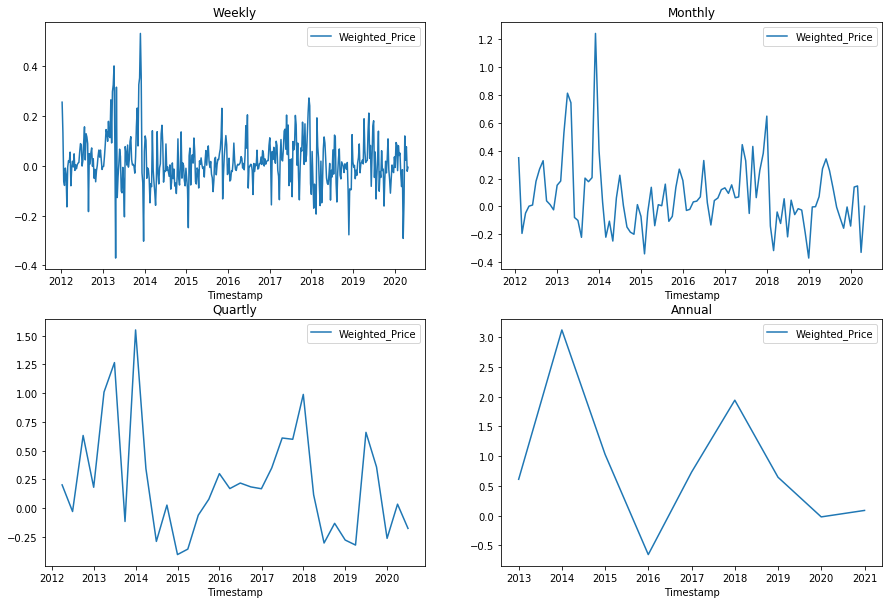

In [46]:
# check out the grow rate series
plt.figure(figsize = (15, 10))
plt.subplot(221)
plt.title('Weekly')
sns.lineplot(data = growth_rate_weekly)
plt.subplot(222)
plt.title('Monthly')
sns.lineplot(data = growth_rate_monthly)
plt.subplot(223)
plt.title('Quartly')
sns.lineplot(data = growth_rate_quarterly)
plt.subplot(224)
plt.title('Annual')
sns.lineplot(data = growth_rate_annual)

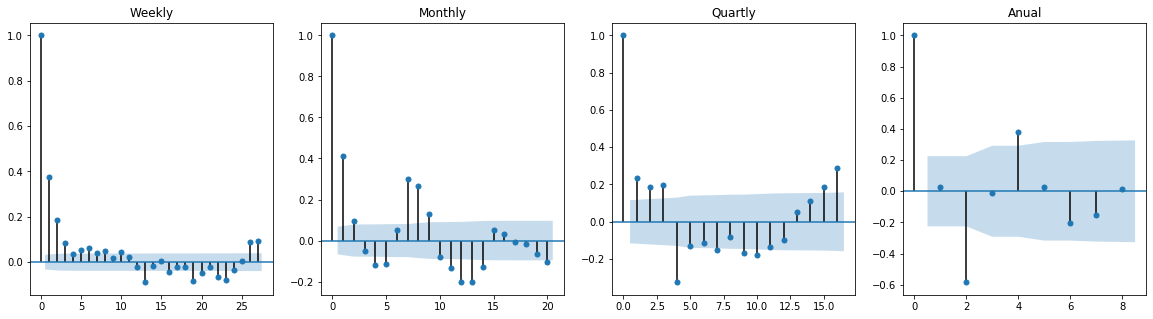

In [9]:
#acf plot
fig, ax = plt.subplots(1,4, figsize = (20, 5))
weekly = plot_acf(growth_rate_weekly[1:], title = 'Weekly', ax=ax[0], alpha = 0.5)
monthly = plot_acf(growth_rate_monthly[1:], title = 'Monthly', ax=ax[1], alpha = 0.5)
quarterly = plot_acf(growth_rate_quarterly[1:], title = 'Quartly', ax=ax[2], alpha = 0.5)
annual = plot_acf(growth_rate_annual[1:], title = 'Anual', ax=ax[3], alpha = 0.5)

plt.savefig('growth_rate_acf')

We can see that lag 1, 2, 3 for weekly growth rate and lag 1 for montly grow rate display significant autocorrelation. We would consider first, second, and third MA model for weekly growth rate and first order MA model for monthly growth rate.

/Users/liwenhuang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


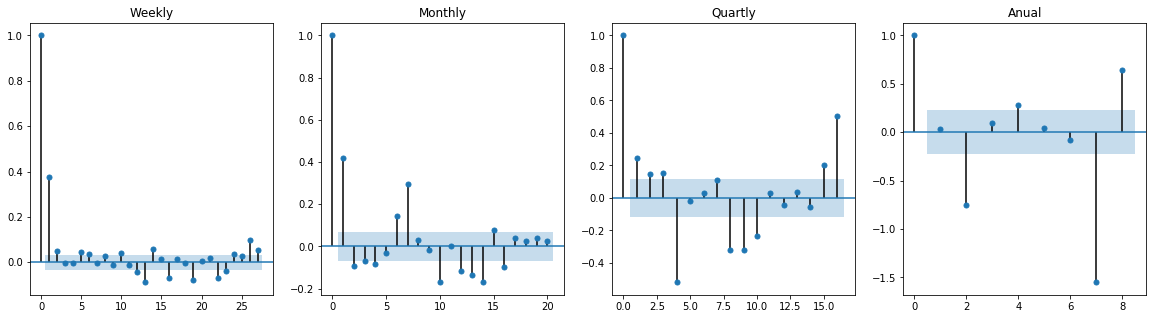

In [10]:
#pacf plot
fig, ax = plt.subplots(1,4, figsize = (20, 5))
weekly = plot_pacf(growth_rate_weekly[1:], title = 'Weekly', ax=ax[0], alpha = 0.5)
monthly = plot_pacf(growth_rate_monthly[1:], title = 'Monthly', ax=ax[1], alpha = 0.5)
quarterly = plot_pacf(growth_rate_quarterly[1:], title = 'Quartly', ax=ax[2], alpha = 0.5)
annual = plot_pacf(growth_rate_annual[1:], title = 'Anual', ax=ax[3], alpha = 0.5)

plt.savefig('growth_rate_pacf')

We can see that in both weekly and monthly growth rate, one lag display significant partial autocorrelation and two lags display negative partical autocorrelation. Later if we are considering AR model, first and second order are candidates for consideration.
At this point, we no longer consider quarterly and annual growth rate as there are two few data points.

In [68]:
print("Dickey–Fuller test for weekly: p=%f" %sm.tsa.stattools.adfuller(growth_rate_weekly.Weighted_Price[1:])[1])
print("Dickey–Fuller test for monthly: p=%f" %sm.tsa.stattools.adfuller(growth_rate_monthly.Weighted_Price[1:])[1])
print("Dickey–Fuller test for quartly: p=%f" %sm.tsa.stattools.adfuller(growth_rate_quarterly.Weighted_Price[1:])[1])
print("Dickey–Fuller test for quartly: p=%f" %sm.tsa.stattools.adfuller(growth_rate_annual.Weighted_Price[1:])[1])

Dickey–Fuller test for weekly: p=0.000000
Dickey–Fuller test for monthly: p=0.000000
Dickey–Fuller test for quartly: p=0.022326
Dickey–Fuller test for quartly: p=0.000000


Using 0.05 as cut-off, all four series pass the stationary check.

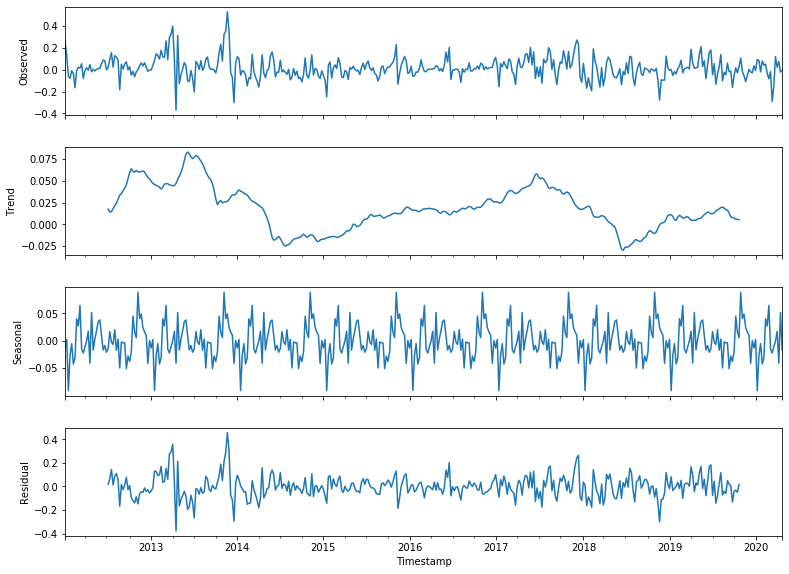

In [69]:
pd.plotting.register_matplotlib_converters()
# STL-decomposition
sm.tsa.seasonal_decompose(growth_rate_weekly.Weighted_Price[1:]).plot()   
#print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(diff_month.price[1:])[1])
plt.gcf().set_size_inches(12, 9)

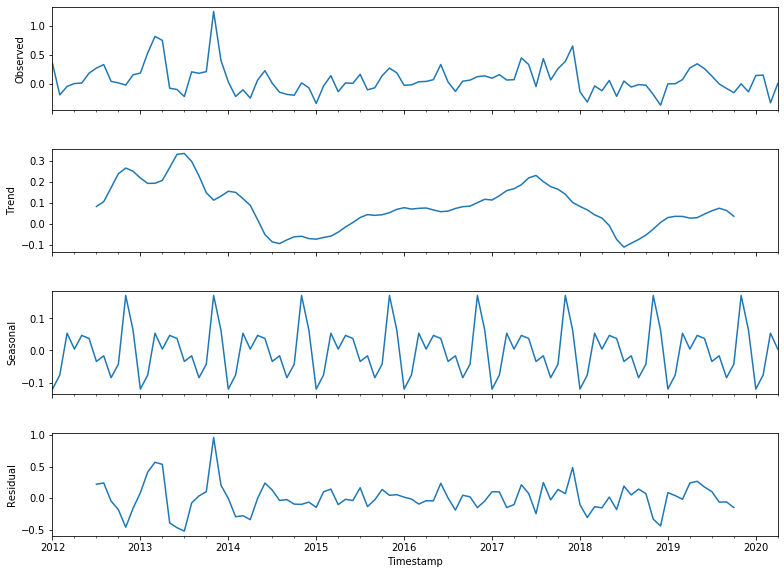

In [70]:
pd.plotting.register_matplotlib_converters()
# STL-decomposition
sm.tsa.seasonal_decompose(growth_rate_monthly.Weighted_Price[1:]).plot()   
#print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(diff_month.price[1:])[1])
plt.gcf().set_size_inches(12, 9)

# ARIMA 

In the exploratory analysis of the grow rate series, we already discuss (1, 2) as potential candiates for AR and (1) for MA for the monthly growth rate; then (1, 2) as potential candiates for AR and (1, 2, 3) for MA for the weekly growth rate. We would explore which combination gives us the best predictions.

In combination, ARIMA model with 0-1 shift probably gives the best result.Let's review the ARIMA model parameters:

p: the parameter associated with the auto-regressive aspect of the model, which incorporates past values -- This is the AR order.

d : the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series -- This is the number of differences.

q: the parameter associated with the moving average part of the model -- this is the MA order.

If you model has a seasonal component , we use a seasonal ARIMA model (SARIMA). In that case we have another set of parameters: P,D, and Q which describe the same associations as p,d, and q, but correspond with the seasonal components of the model.

In this case, it makes more sense to apply a seasonal ARIMA model.

In [8]:
#from statsmodels.tsa.arima_model import ARIMA
import warnings

## Model Selection

In [9]:
# we use the weekly growth rate for modeling
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 4)
ps = range(0, 3)
D = 0 # since we already take one difference therefore we set d to be 0
d = 0
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(growth_rate_weekly.Weighted_Price, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])


In [10]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
24  (1, 0, 0, 0) -830.864528
32  (1, 1, 0, 0) -830.614251
48  (2, 0, 0, 0) -830.584889
26  (1, 0, 1, 0) -828.930600
25  (1, 0, 0, 1) -828.930435
                           Statespace Model Results                           
Dep. Variable:         Weighted_Price   No. Observations:                  435
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 417.432
Date:                Sat, 16 May 2020   AIC                           -830.865
Time:                        14:03:37   BIC                           -822.714
Sample:                    01-01-2012   HQIC                          -827.648
                         - 04-26-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3984      0.025    

In [26]:
# model = ARIMA(growth_rate_monthly[1:], order=(2,0,1))
# model_fit = model.fit(disp=0)
# print(model_fit.summary())

## Resisual Analysis

Dickey–Fuller test:: p=0.000000


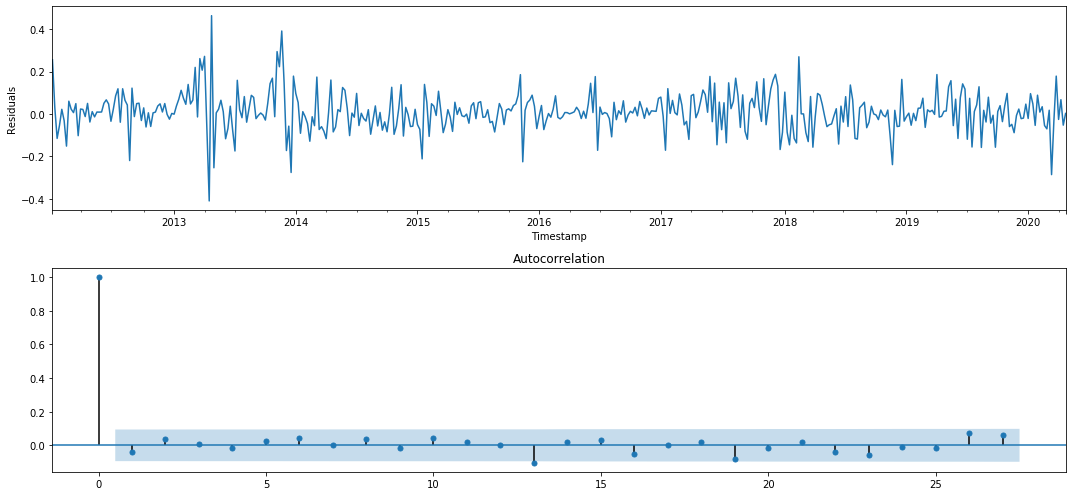

In [11]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[1:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[1:].values.squeeze(), ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[1:])[1])

plt.tight_layout()
plt.show()

## Prediction

As we are using the growth rate time series, we will need to be mindful to restore the prediction back to its normal scale.

In [23]:
#growth_rate_monthly.dropna(inplace = True)
growth_rate_weekly.columns = ['actual_growth_rate']

In [32]:
growth_rate_weekly

,actual_growth_rate,predicted_grow_rate
2012-01-01,NaN,NaN
2012-01-08,0.255654,0.000000e+00
2012-01-15,0.133071,1.018545e-01
2012-01-22,-0.061722,5.301657e-02
2012-01-29,-0.078662,-2.459061e-02
...,...,...
2020-07-19,NaN,-9.330701e-08
2020-07-26,NaN,-3.717425e-08
2020-08-02,NaN,-1.481051e-08
2020-08-09,NaN,-5.900624e-09


In [14]:
# make the prediction, end points set to be a few months out into the future, we will forecast 15 weeks
forecast = best_model.predict(start=1, end=450)
forecast.name = 'forecast'
forecast = forecast.to_frame()
forecast.columns = ['predicted_grow_rate']

In [25]:
# merge the prediction grow rates with the acutal grow rates
growth_rate_weekly = growth_rate_weekly.join(forecast, how ='outer')

In [26]:
# add the prediction as a new column to the monthly log price
#bit_month['log_price_forecast'] = bit_month['log_price'].shift(1) + bit_month['log_diff_forecast']
bit_weekly_log.columns = ['weighted_price_log']
bit_weekly_log['predicted_weighted_price_log'] = bit_weekly_log['weighted_price_log'].shift(1) + growth_rate_weekly['predicted_grow_rate']

In [34]:
# use a final dataset to merge original log data and log difference together
#bit_weekly_log.columns = ['weighted_price_log']
final_data = bit_weekly_log.join(growth_rate_weekly, how = 'outer')

In [38]:
final_data.tail(20)

,weighted_price_log,predicted_weighted_price_log,actual_growth_rate,predicted_grow_rate
2020-04-05,8.793608,8.818971,0.022486,4.784957e-02
2020-04-12,8.870176,8.802567,0.076568,8.958668e-03
2020-04-19,8.848404,8.900681,-0.021772,3.050525e-02
2020-04-26,8.842570,8.839730,-0.005834,-8.674001e-03
2020-05-03,NaN,NaN,NaN,-2.324382e-03
2020-05-10,NaN,NaN,NaN,-9.260519e-04
2020-05-17,NaN,NaN,NaN,-3.689463e-04
2020-05-24,NaN,NaN,NaN,-1.469911e-04
2020-05-31,NaN,NaN,NaN,-5.856242e-05
2020-06-07,NaN,NaN,NaN,-2.333173e-05


In [39]:
subset = final_data.loc['2020-04-26':]

In [40]:
# this is the prediction that we need to fill in
subset

,weighted_price_log,predicted_weighted_price_log,actual_growth_rate,predicted_grow_rate
2020-04-26,8.84257,8.83973,-0.005834,-8.674001e-03
2020-05-03,NaN,NaN,NaN,-2.324382e-03
2020-05-10,NaN,NaN,NaN,-9.260519e-04
2020-05-17,NaN,NaN,NaN,-3.689463e-04
2020-05-24,NaN,NaN,NaN,-1.469911e-04
2020-05-31,NaN,NaN,NaN,-5.856242e-05
2020-06-07,NaN,NaN,NaN,-2.333173e-05
2020-06-14,NaN,NaN,NaN,-9.295544e-06
2020-06-21,NaN,NaN,NaN,-3.703418e-06
2020-06-28,NaN,NaN,NaN,-1.475471e-06


In [41]:
predicted_grow_rate = subset['predicted_grow_rate']
weighted_price_log = subset['weighted_price_log']
predicted_weighted_price_log = subset['predicted_weighted_price_log']

In [44]:
predicted_weighted_price_log

2020-04-26    8.83973
2020-05-03        NaN
2020-05-10        NaN
2020-05-17        NaN
2020-05-24        NaN
2020-05-31        NaN
2020-06-07        NaN
2020-06-14        NaN
2020-06-21        NaN
2020-06-28        NaN
2020-07-05        NaN
2020-07-12        NaN
2020-07-19        NaN
2020-07-26        NaN
2020-08-02        NaN
2020-08-09        NaN
2020-08-16        NaN
Freq: W-SUN, Name: predicted_weighted_price_log, dtype: float64

In [45]:
for i in range(1, len(predicted_grow_rate)):
    predicted_weighted_price_log[i] = predicted_weighted_price_log[i-1] + predicted_grow_rate[i]

In [46]:
subset['predicted_weighted_price_log'] = predicted_weighted_price_log 

In [47]:
# fill in the prediction in the final data set
final_data.loc['2020-05-03':, 'predicted_weighted_price_log'] = predicted_weighted_price_log[1:]

In [48]:
# check the last few rows
final_data.tail()

,weighted_price_log,predicted_weighted_price_log,actual_growth_rate,predicted_grow_rate
2020-07-19,NaN,8.835866,NaN,-9.330701e-08
2020-07-26,NaN,8.835866,NaN,-3.717425e-08
2020-08-02,NaN,8.835866,NaN,-1.481051e-08
2020-08-09,NaN,8.835866,NaN,-5.900624e-09
2020-08-16,NaN,8.835866,NaN,-2.350855e-09


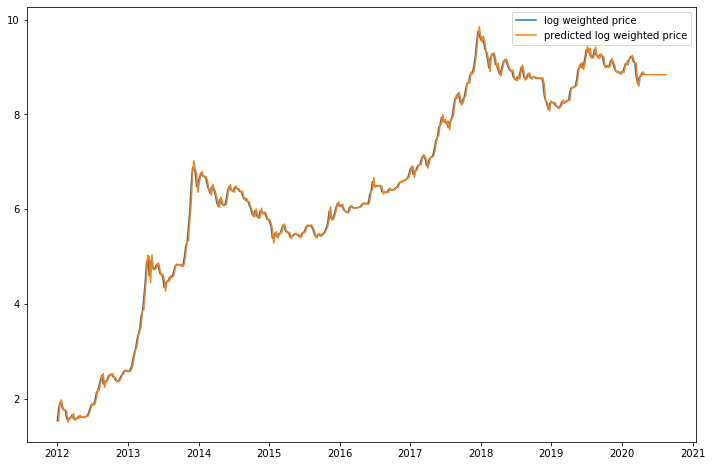

In [49]:
plt.figure(figsize = (12, 8))
sns.lineplot(data = final_data['weighted_price_log'], label = 'log weighted price')
sns.lineplot(data = final_data['predicted_weighted_price_log'], label = 'predicted log weighted price')

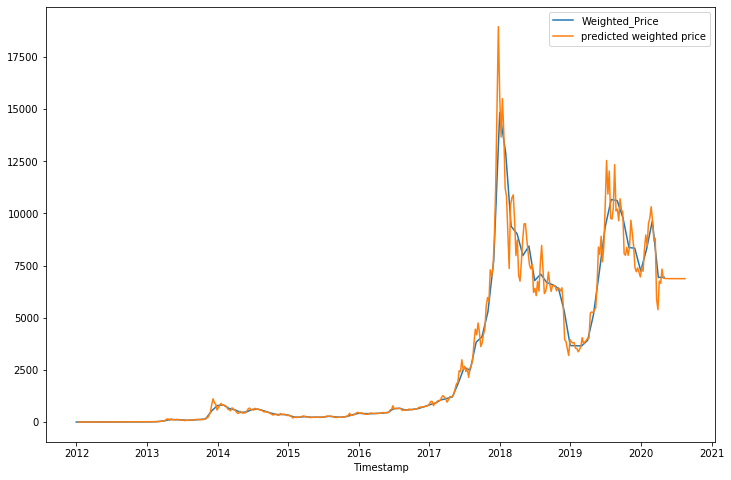

In [50]:
# restore the prediction to original usd dollars scale
plt.figure(figsize = (12, 8))
sns.lineplot(data = bit_monthly)
sns.lineplot(data = np.exp(final_data['predicted_weighted_price_log']), label = 'predicted weighted price')

# Prophet

Facebook's Prophet use Bayesian based curve fitting method to forecast the time series data. It is so powerful and scarrily easy to use. Here, we would try it out and see if it does a better job than the ARIMA model.

In [354]:
from fbprophet import Prophet

In [351]:
# format the data to the requirement of the prophet requirement, ds for datetime and y for price index
bit = bit_log.reset_index()
bit.columns = ['ds', 'y']

In [352]:
bit.head()

,ds,y
0,2014-12-01,5.913503
1,2014-12-02,5.934894
2,2014-12-03,5.934894
3,2014-12-04,5.932510
4,2014-12-06,5.934894


In [353]:
bit['ds'].min(), bit['ds'].max()

(Timestamp('2014-12-01 00:00:00'), Timestamp('2020-05-04 00:00:00'))

In [355]:
# initiate a prophet object to fit the data
m = Prophet()
m.fit(bit)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/liwenhuang/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [363]:
# make a future prediction the next month
future = m.make_future_dataframe(periods = 120)
future.tail() # note that the original data set only has 1941 rows, 30 new rows have been added

,ds
2063,2020-08-28
2064,2020-08-29
2065,2020-08-30
2066,2020-08-31
2067,2020-09-01


In [364]:
forecast = m.predict(future)

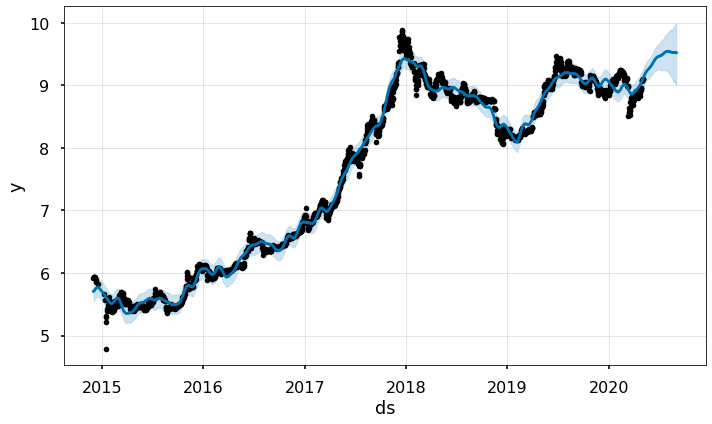

In [365]:
#from fbprophet.plot import add_changepoints_to_plot
fig1 = m.plot(forecast)
#a = add_changepoints_to_plot(fig1.gca(), m, forecast)

In [359]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1973,2020-05-30,9.294639,9.134412,9.444695
1974,2020-05-31,9.299173,9.121152,9.462043
1975,2020-06-01,9.308199,9.133875,9.469123
1976,2020-06-02,9.312870,9.142227,9.468257
1977,2020-06-03,9.315612,9.141649,9.476313


In [360]:
next_month = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

In [361]:
next_month['ds'] = pd.to_datetime(next_month['ds'])
next_month = next_month.set_index('ds')

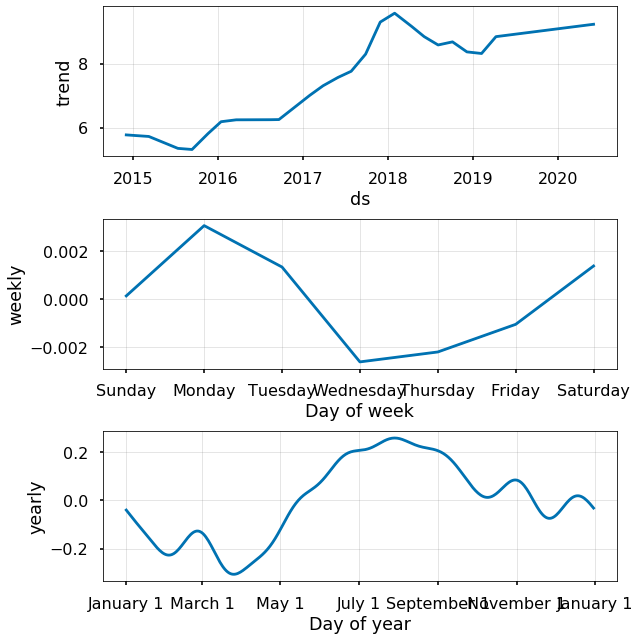

In [362]:
fig2 = m.plot_components(forecast)

# Conclusion

As we can see the seasonal ARIMA model give two entirely different predictions. This leads us to conclude that time series forecast for bitcoin price is equally, if not more problematic then the linear model and random forest model.

The critical issue with time series forecast technique is that it entirely discount the fact that bitcoin price is also impacted by many outsid factors, such as the overall economy, the cash supply available, the perceived values of bitcoin.

reference for this notebook 

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

https://www.kaggle.com/myonin/bitcoin-price-prediction-by-arima

https://www.youtube.com/watch?v=e8Yw4alG16Q

https://towardsdatascience.com/forecasting-with-prophet-d50bbfe95f91
